In [ ]:
%pip install Datasets

# Wens Method
This a method to generate numerical representation fo DNA that takes into account both local and global information. The method is based on (this)[https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5953932/] paper. The method is based on a weighted graphical representation of a sequence. 

### Graphical Representation
We can represent a DNA sequence as the sum of its component sequences(A,T,C,G). These subsequences can themselves be represented graphically. 

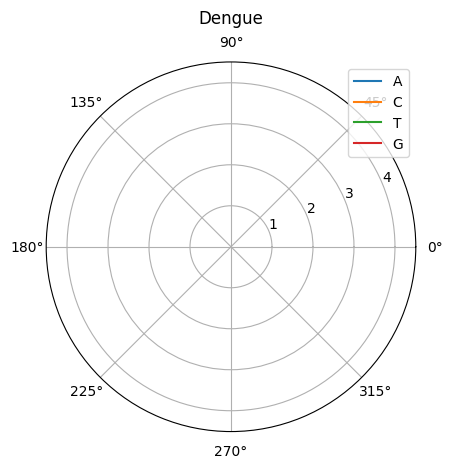

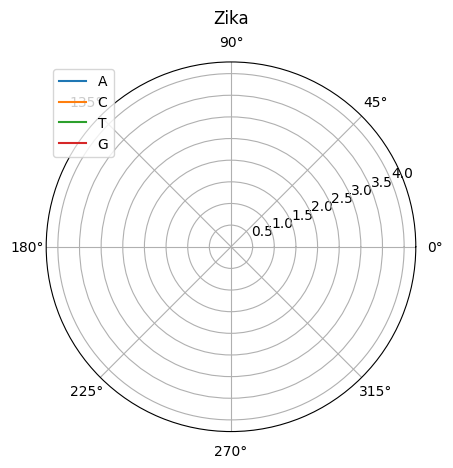

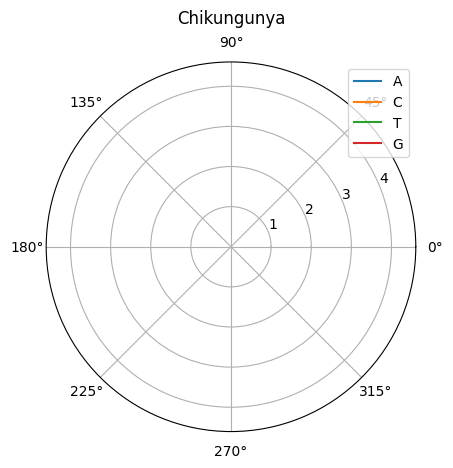

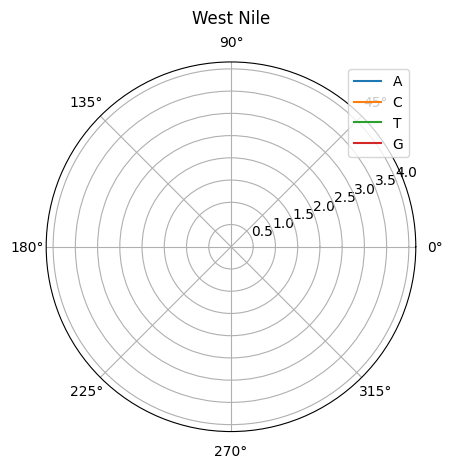

In [48]:
import re
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

# Loading an example dataset
dataset = load_dataset("Hack90/virus_10kbp_50kbp")

# List of virus names
viruses = ['Dengue', 'Zika', 'Chikungunya', 'West Nile']

# Dictionary comprehension to filter dataset and get sequences
virus_sequences = {virus: dataset['train'].filter(lambda example: virus.lower() in example['description'].lower())['sequence'] for virus in viruses}

# Compile a regular expression that matches characters that are not 'a', 't', 'c', or 'g'
invalid_chars_re = re.compile('[^atcg]', re.IGNORECASE)

# Use the regular expression to remove invalid characters from the sequences
virus_sequences = {virus: [invalid_chars_re.sub('', seq.lower()) for seq in virus_sequences[virus]] for virus in virus_sequences}

# Calculate the minimum sequence length
lowest_length = min(len(seq) for seq in virus_sequences.values())

# splitting sequences into subsequences of a,t,c,g
def _get_subsequences(sequence):
    subsequences_values = list(map(lambda x: [i+1 for i, nuc in enumerate(sequence) if nuc == x], 'actg'))
    subsequences_key = ['A', 'C', 'T', 'G']
    subsequences = dict(zip(subsequences_key, subsequences_values))
    return subsequences

def _calculate_coordinates_fixed(subsequence, L = lowest_length):
    coordinates = []
    for a in subsequence:
        theta = ((2 * np.pi) / (L - 1)) * (len(subsequence)-1)
        rho = np.sqrt(theta)
        coordinates.append((theta, rho))
    return coordinates

def _plot_coordinates(subsequences, virus):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    for subsequence, coordinates in subsequences.items():
        theta, r = zip(*coordinates)
        ax.plot(theta, r, label=subsequence)
    ax.grid(True)
    ax.set_title(f"{virus}", va='bottom')
    ax.legend()
    plt.show()
    
    
for virus in virus_sequences:
        sequence =  virus_sequences[virus][0]
        subsequences = _get_subsequences(sequence)
        coordinates = {subsequence: _calculate_coordinates_fixed(subsequences[subsequence]) for subsequence in subsequences}
        _plot_coordinates(coordinates, virus)

We can add a weighting to our sequences. This weighting would measure repetition and compactness. 

In [42]:
def _calculate_weighting_full(sequence, weights, L = 5000, E = 0.0375):
    weightings = [0]  # Starting with a default weight for the first nucleotide
    for i in range(1, len(sequence) - 1):  # Adjusted to handle up to the penultimate nucleotide
        if i < len(sequence) - 2:  # Ensure there's room for comparison
            subsequence = sequence[i-1:i+3]
            subsequence_1 = subsequence[1]
            subsequence_0 = '1' if subsequence[0] == subsequence_1 else '0'
            subsequence_2 = '1' if subsequence[2] == subsequence_1 else '0'
            subsequence_3 = '1' if subsequence[3] == subsequence_1 else '0'
            comparison_pattern = subsequence_0 + '1' + subsequence_2 + subsequence_3
            weight = weights.get(comparison_pattern, 0)# Use .get to safely handle missing patterns
            if i > L: 
                weight = weight * E # this is a simple way to decrease the weight of the nucleotides that are far from minimal sequence length
        else:
            # For the last two nucleotides, where a full comparison isn't possible
            weight = 0
        weightings.append(weight)
    weightings.append(0)  # Adding a default weight for the last nucleotide

    return weightings

# Testing the weighting function
weights = {'0100': 1/6, '0101': 2/6, '1100' : 3/6, '0110':3/6, '1101': 4/6, '1110': 5/6,'0111':5/6, '1111': 6/6}
_calculate_weighting_full('atcgtcgaaaa', weights)


[0,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.8333333333333334,
 1.0,
 0,
 0]

In [43]:
def _centre_of_mass(polar_coordinates, weightings):
    standard_cordinates = _calculate_standard_coordinates(polar_coordinates)
    x, y = standard_cordinates
    total = 0 
    for i in range(len(x)):
        total += (weightings[i] * ((x[i] - (x[i]*weightings[i]))**2 + (y[i] - y[i]*weightings[i])**2))
    return total
        
def normalised_moment_of_inertia(polar_coordinates, weightings):
    moment = _centre_of_mass(polar_coordinates, weightings)
    moment = moment / sum(weightings)
    moment = np.sqrt(moment)
    return moment

In [46]:
# Adjust the _calculate_standard_coordinates function to handle the correct data structure
def _calculate_standard_coordinates(polar_coordinates):
    x = [rho * np.cos(theta) for theta, rho in polar_coordinates]
    y = [rho * np.sin(theta) for theta, rho in polar_coordinates]
    return (x, y)

def similarity(normalised_moment_of_inertia_1:list, normalised_moment_of_inertia_2:list):
    total = 0
    for i in range(len(normalised_moment_of_inertia_1)):
        total += (normalised_moment_of_inertia_1[i] - normalised_moment_of_inertia_2[i])**2
    total = np.sqrt(total)
    return total

def _moments_of_inertia(polar_coordinates, weightings):
    moments = []
    for subsequence, indices in polar_coordinates.items():
        moments.append(normalised_moment_of_inertia(indices, weightings))     
    return moments

def moment_of_inertia(sequence, weights, L = 5000, E = 0.0375):
    subsequences = _get_subsequences(sequence)
    polar_coordinates = {subsequence: _calculate_coordinates_fixed(indices, len(virus_sequences['Dengue'][0]), L=L) for subsequence, indices in subsequences.items()}
    weightings = _calculate_weighting_full(sequence, weights)
    moments = _moments_of_inertia(polar_coordinates, weightings)
    return moments    

In [47]:
dengue = moment_of_inertia(virus_sequences['Dengue'][0], weights)
zika = moment_of_inertia(virus_sequences['Chikungunya'][98], weights)
print(similarity(dengue, zika))

TypeError: _get_subsequences() got an unexpected keyword argument 'L'

In [26]:
virus_sequences['Dengue'][0]

'tagaaagagtgtgagcaaattacatgtacttgtgcataaattcagcagtaatgtataatgatctaaattaaataaaaaatttaaatagttttttaaatatgaggatgctgattttgagagccactcccagatgagcaaggcgcatgcccttctcggaggaccaacctagggacttggttcaggtgggtggtgttttaattccattagggaaaatgatgccctgtaaatcgacgagcagttggaccgacaagaacagtttcgactcggaagcttgcttaacgtagtgctgacagttttttattagagagcagatttctgatgaacaaccaacggaaaaagacgggaaaaccgtctatcaatatgctgaaacgcgtgagaaaccgtgtgtcaactggatcacagttggcgaagagattctcaagaggattgctgaacggccaaggaccaatgaaattggttatggctttcatagctttcctcagatttctagccattccaccaacagcaggagtcttggctagatggggaaccttcaagaagtcaggggctattaaggtcctaaaaggcttcaagagggagatttcaaacatgctgagcattatcaacaaaaggaaaaagacatcgctctgcctcatgatgatgttaccagcaacacttgctttccacttgacttcacgcgatggagagccgcgcatgattgtggggaagaatgaaagagggaaatccctactttttaagacagctactggaatcaacatgtgcacactcatagctatggacttgggagagatgtgtgatgacacggtcacttataaatgccccctcattgccgaagtggaacctgaagacattgactgctggtgcaaccttacatcgacatgggtgacttacggaacgtgcaatcaagctggggagcatagacgcgacaagagatcagtggcgttagctccccatgtcggcatgggactggacacacgtacccaaacctggatgtcggct